# Sampling on all angles

Sample on all angles learned by model

In [1]:
import os, sys
import logging
import json
import glob
import importlib
import math

import torch

import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
#############

SRC_DIR = os.path.join(
    os.path.dirname(os.getcwd()), "protdiff"
)
assert os.path.isdir(SRC_DIR)
sys.path.append(SRC_DIR)
import beta_schedules
import datasets
import plotting
import sampling
import modelling
import utils

BIN_DIR = os.path.join(
    os.path.dirname(os.getcwd()), "bin"
)
assert os.path.isdir(BIN_DIR)
sys.path.append(BIN_DIR)
import train as train_bin

logging.basicConfig(level=logging.INFO)

In [16]:
MODEL_DIR = "/home/t-kevinwu/amlt/normal-cattle/cath_full_run/results"
with open(os.path.join(MODEL_DIR, "training_args.json")) as source:
    training_args = json.load(source)
training_args


{'results_dir': '/mnt/output/projects/protdiff-cath/amlt-results/7338681229.16372-84eef1ad-2143-4623-8cc0-55efdc920b5e/results',
 'angles_definitions': 'canonical',
 'shift_angles_zero_twopi': False,
 'noise_prior': 'gaussian',
 'timesteps': 250,
 'variance_schedule': 'linear',
 'variance_scale': 1.0,
 'implementation': 'huggingface_encoder',
 'time_encoding': 'gaussian_fourier',
 'num_hidden_layers': 12,
 'hidden_size': 384,
 'intermediate_size': 768,
 'num_heads': 12,
 'position_embedding_type': 'absolute',
 'dropout_p': 0.1,
 'decoder': 'mlp',
 'gradient_clip': 1.0,
 'batch_size': 64,
 'lr': 5e-05,
 'loss': 'smooth_l1',
 'l2_norm': 0.0,
 'l1_norm': 0.0,
 'circle_reg': 0.0,
 'min_epochs': 10000,
 'max_epochs': 10000,
 'early_stop_patience': 0,
 'lr_scheduler': '',
 'use_swa': False,
 'subset': None,
 'exhaustive_validation_t': False,
 'syn_noiser': '',
 'single_dist_debug': False,
 'single_angle_debug': -1,
 'single_timestep_debug': False,
 'cpu_only': False,
 'ngpu': -1,
 'write_val

In [18]:
beta_values = beta_schedules.get_variance_schedule(
    training_args['variance_schedule'],
    training_args['timesteps'],
)
alpha_beta_values = beta_schedules.compute_alphas(beta_values)
alpha_beta_values.keys()

INFO:root:Getting linear variance schedule with 250 timesteps


dict_keys(['betas', 'alphas', 'alphas_cumprod', 'sqrt_alphas_cumprod', 'sqrt_one_minus_alphas_cumprod', 'posterior_variance'])

In [37]:
# Load in the dataset
importlib.reload(train_bin)
importlib.reload(datasets)

train_dset, valid_dset, test_dset = train_bin.get_train_valid_test_sets(
    angles_definitions=training_args['angles_definitions'],
    timesteps=training_args['timesteps'],
    variance_schedule=training_args['variance_schedule'],
    noise_prior=training_args['noise_prior'],
    shift_to_zero_twopi=training_args['shift_angles_zero_twopi'],
    var_scale=training_args['variance_scale'],
    toy=training_args['subset'],
    syn_noiser=training_args['syn_noiser'],
    exhaustive_t=training_args['exhaustive_validation_t'],
    single_dist_debug=training_args['single_dist_debug'],
    single_angle_debug=training_args['single_angle_debug'],
    single_time_debug=training_args['single_timestep_debug'],
)
len(train_dset)

INFO:root:Loading cached full dataset from /home/t-kevinwu/projects/protein_diffusion/protdiff/protdiff/cache_canonical_structures.pkl
INFO:root:Split train contains 25224 structures
INFO:root:Length of angles: 9-1202, mean 152.32354107199492
INFO:root:Loading cached full dataset from /home/t-kevinwu/projects/protein_diffusion/protdiff/protdiff/cache_canonical_structures.pkl
INFO:root:Split validation contains 3153 structures
INFO:root:Length of angles: 13-773, mean 150.05962575325088
INFO:root:Loading cached full dataset from /home/t-kevinwu/projects/protein_diffusion/protdiff/protdiff/cache_canonical_structures.pkl
INFO:root:Split test contains 3154 structures
INFO:root:Length of angles: 13-1072, mean 151.2263792010146
INFO:root:Using <class 'datasets.NoisedAnglesDataset'> for noise
INFO:root:Getting linear variance schedule with 250 timesteps
INFO:root:Getting linear variance schedule with 250 timesteps
INFO:root:Getting linear variance schedule with 250 timesteps
INFO:root:train: N

25224

In [24]:
train_dset.dset.feature_names['angles']

['bond_dist', 'phi', 'psi', 'omega', 'tau']

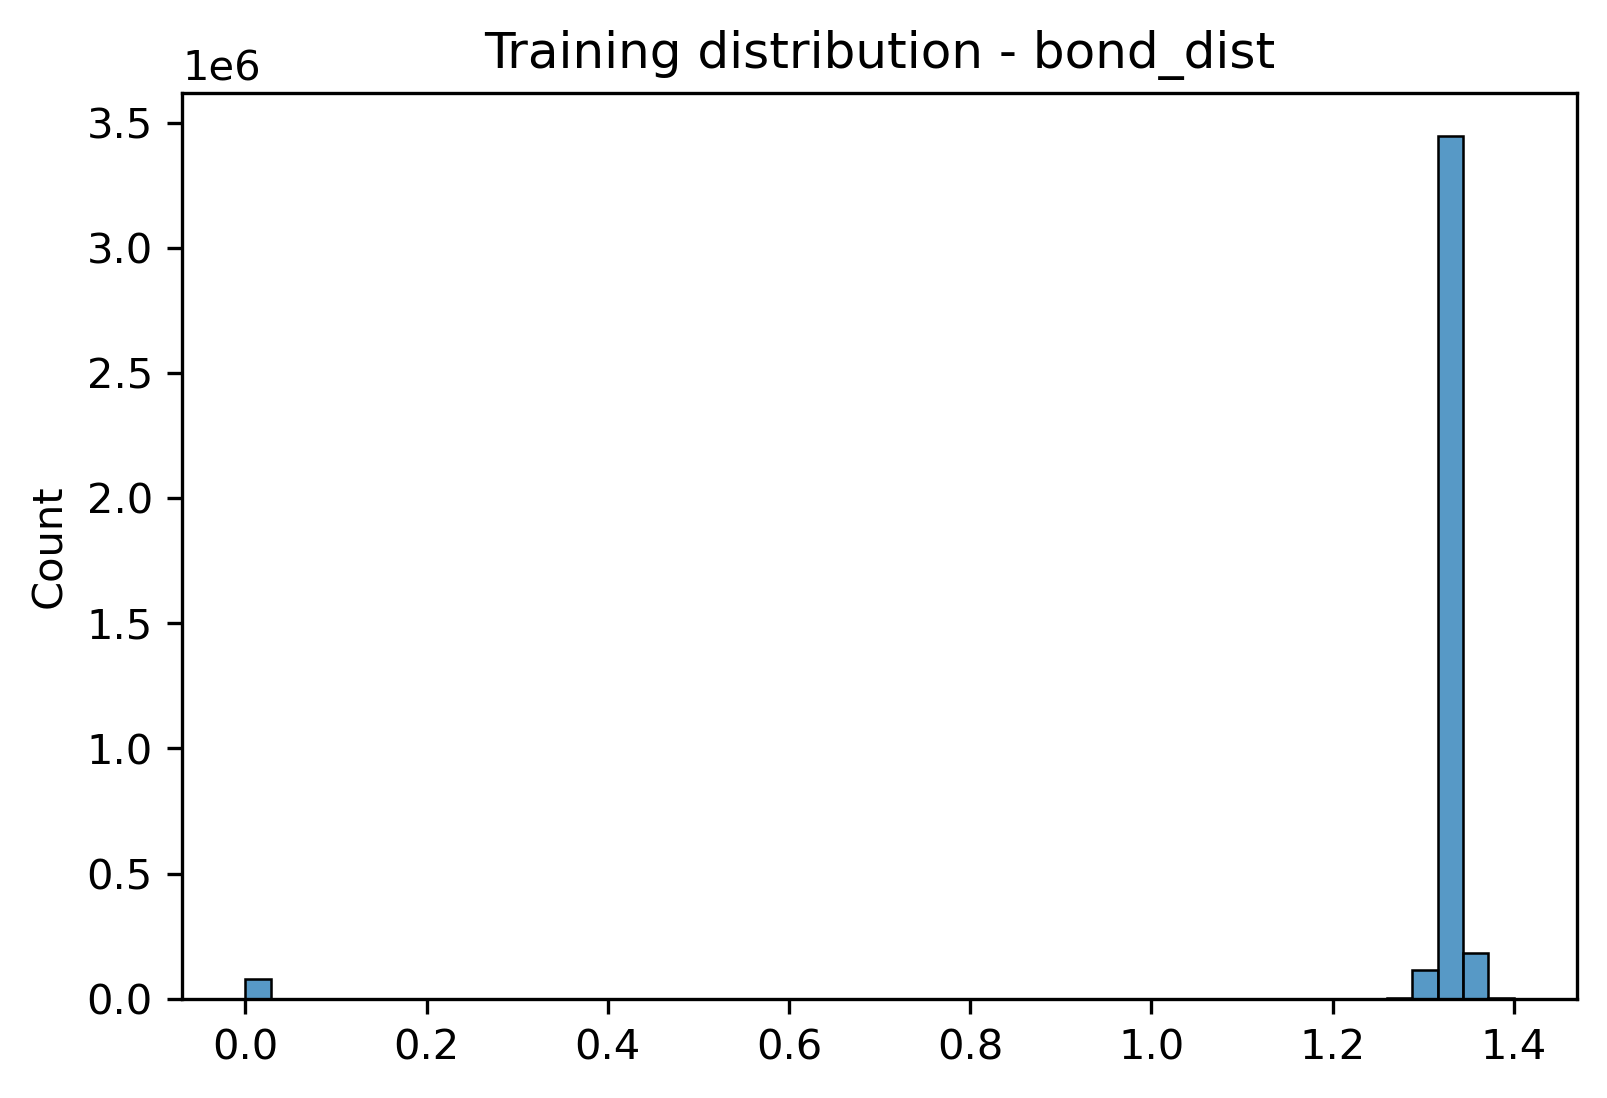

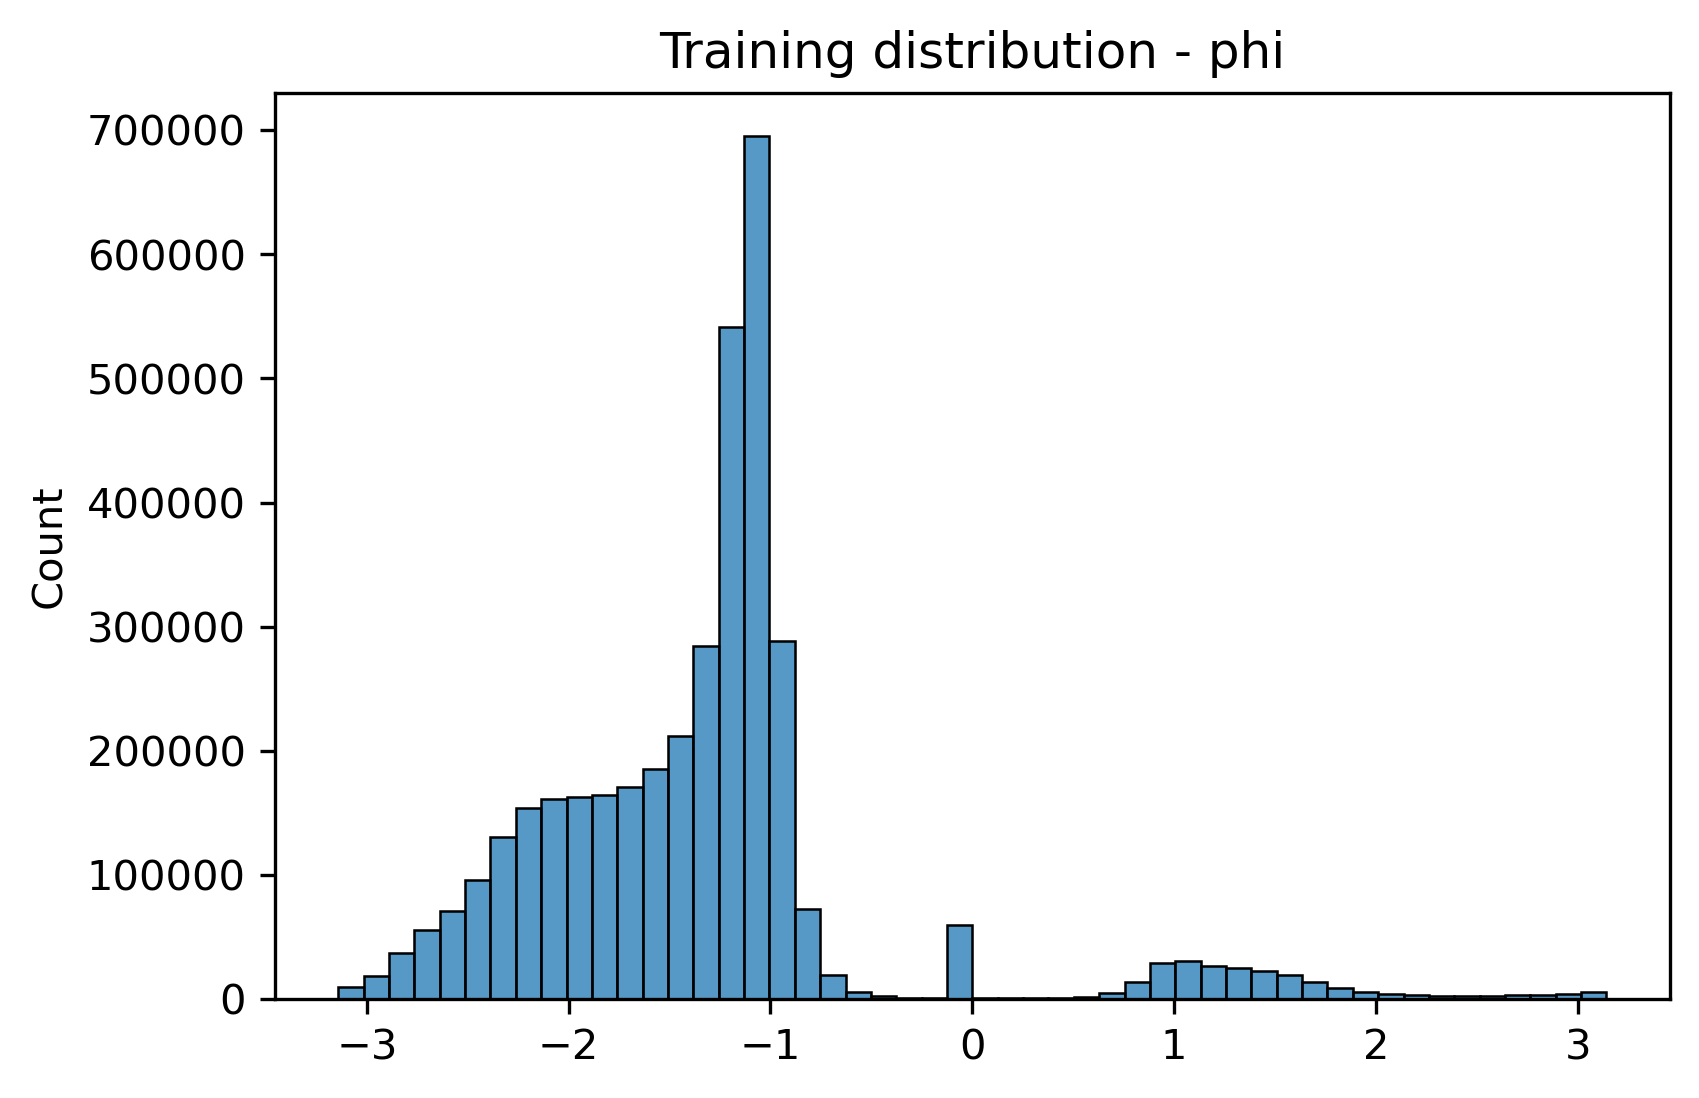

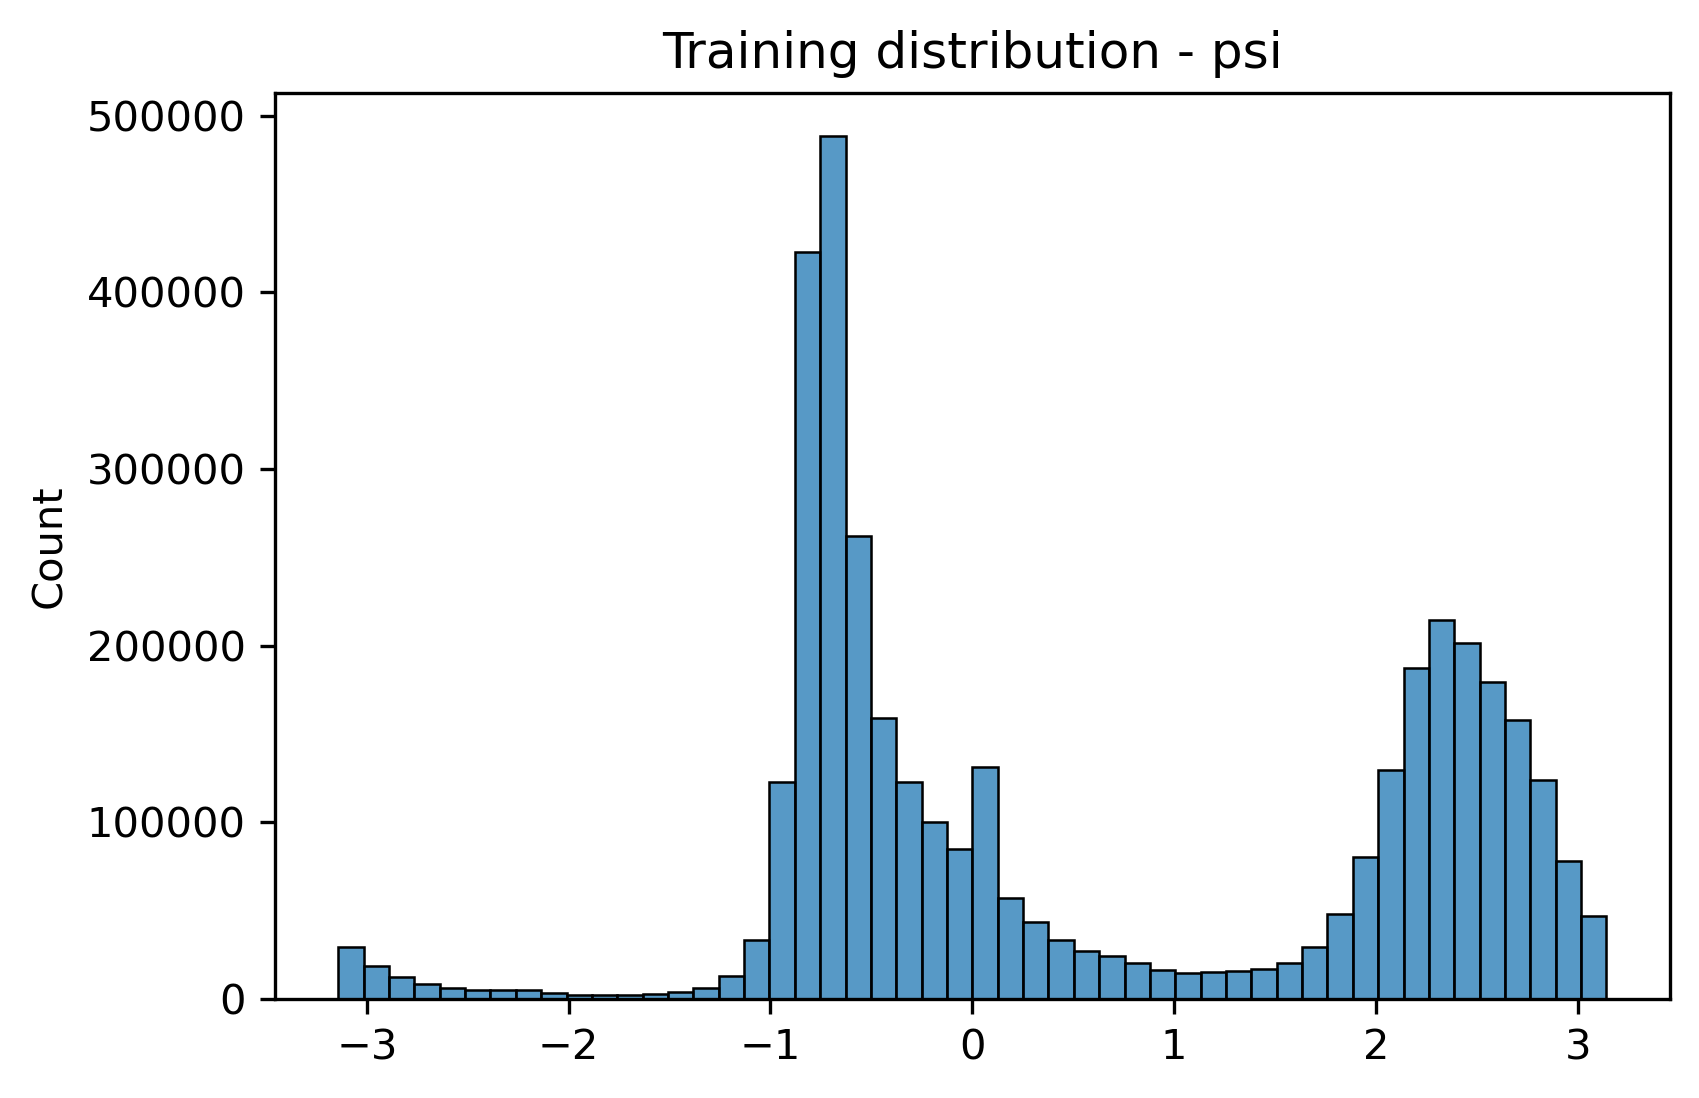

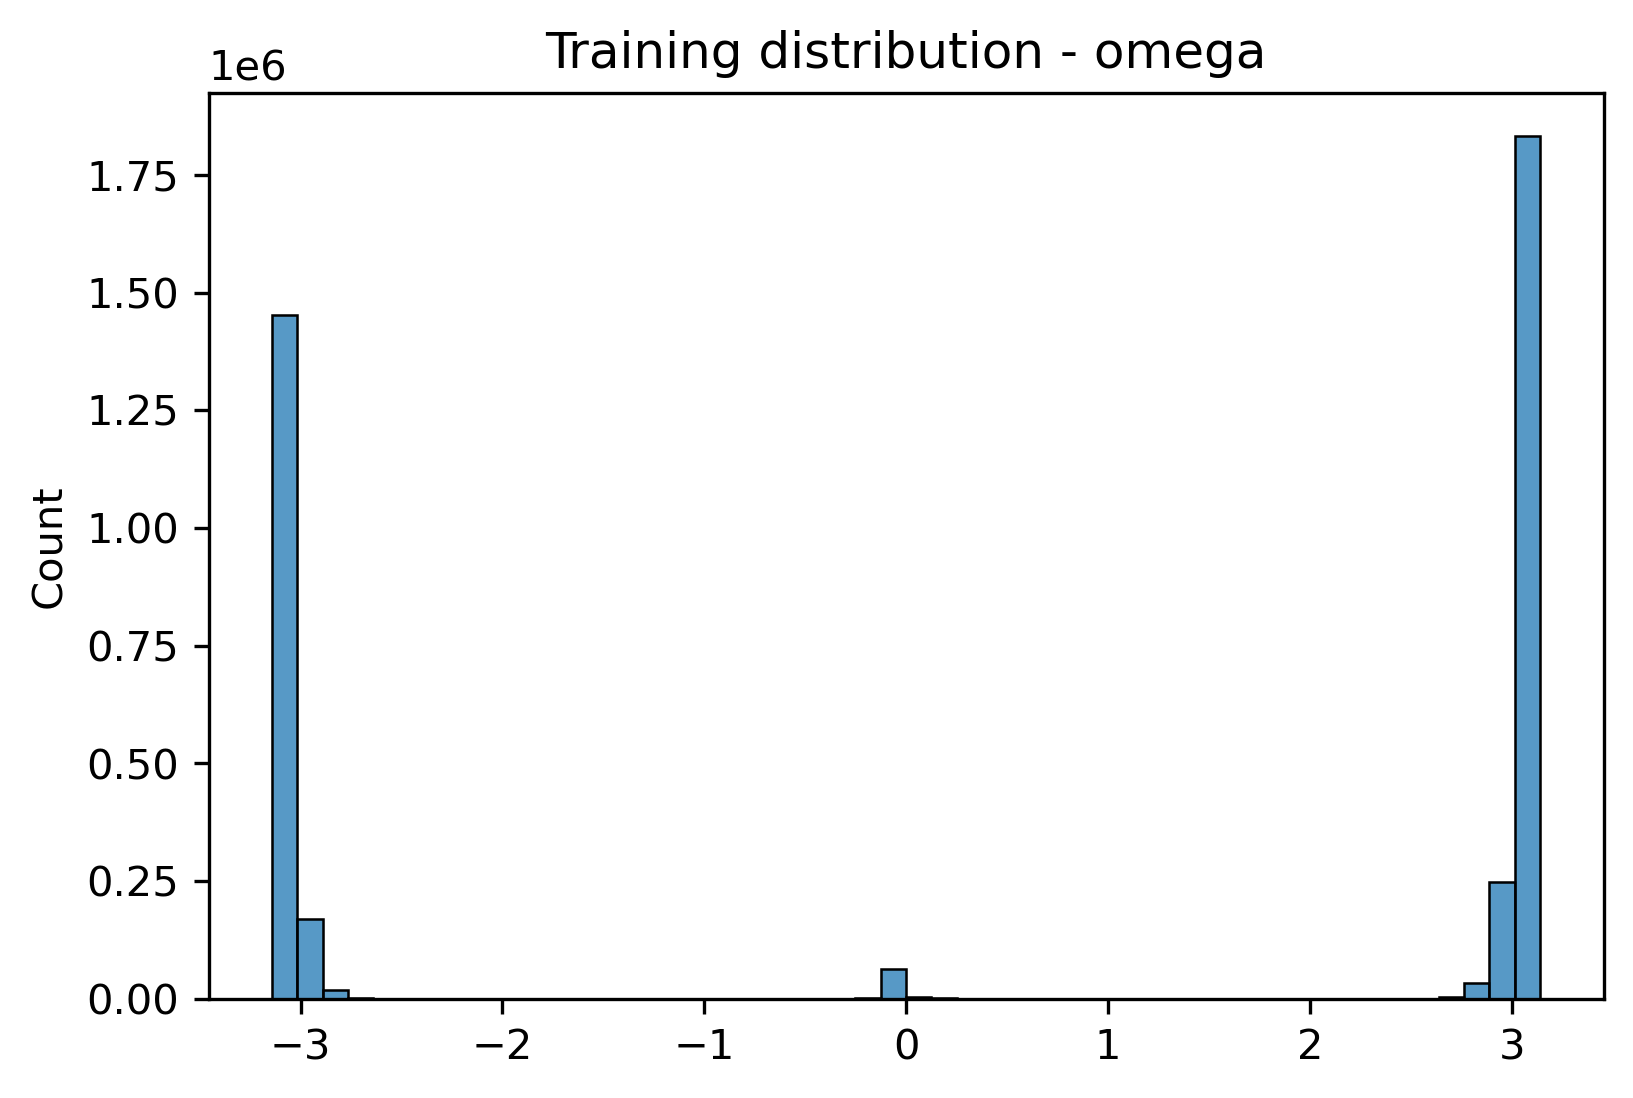

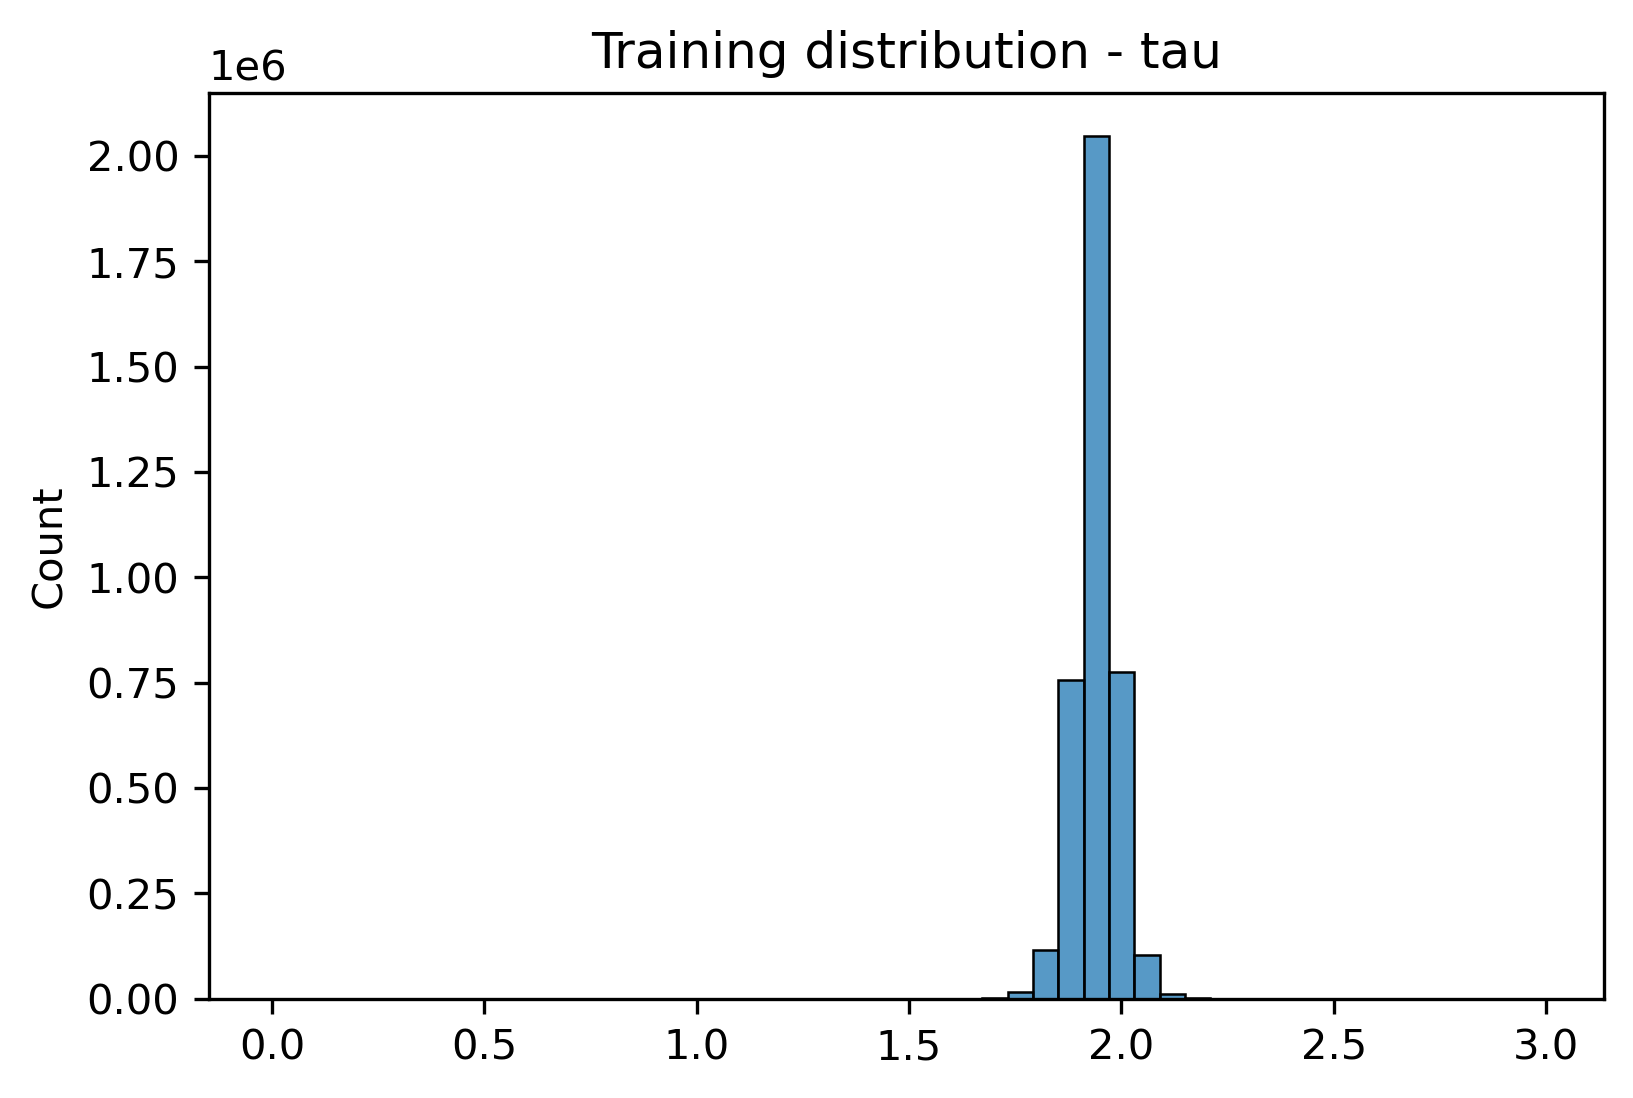

In [27]:
select_by_attn = lambda x: x['angles'][x['attn_mask'] != 0]

# Select the un-noised angles
train_values = [select_by_attn(train_dset.dset[i]) for i in range(len(train_dset))]

train_values_stacked = torch.cat(train_values, dim=0)

for i in range(train_values_stacked.shape[1]):
    ft_name = train_dset.dset.feature_names['angles'][i]
    fig, ax = plt.subplots(dpi=300)
    sns.histplot(train_values_stacked[:, i], bins=50, ax=ax)
    ax.set(title=f"Training distribution - {ft_name}")
    fig.show()

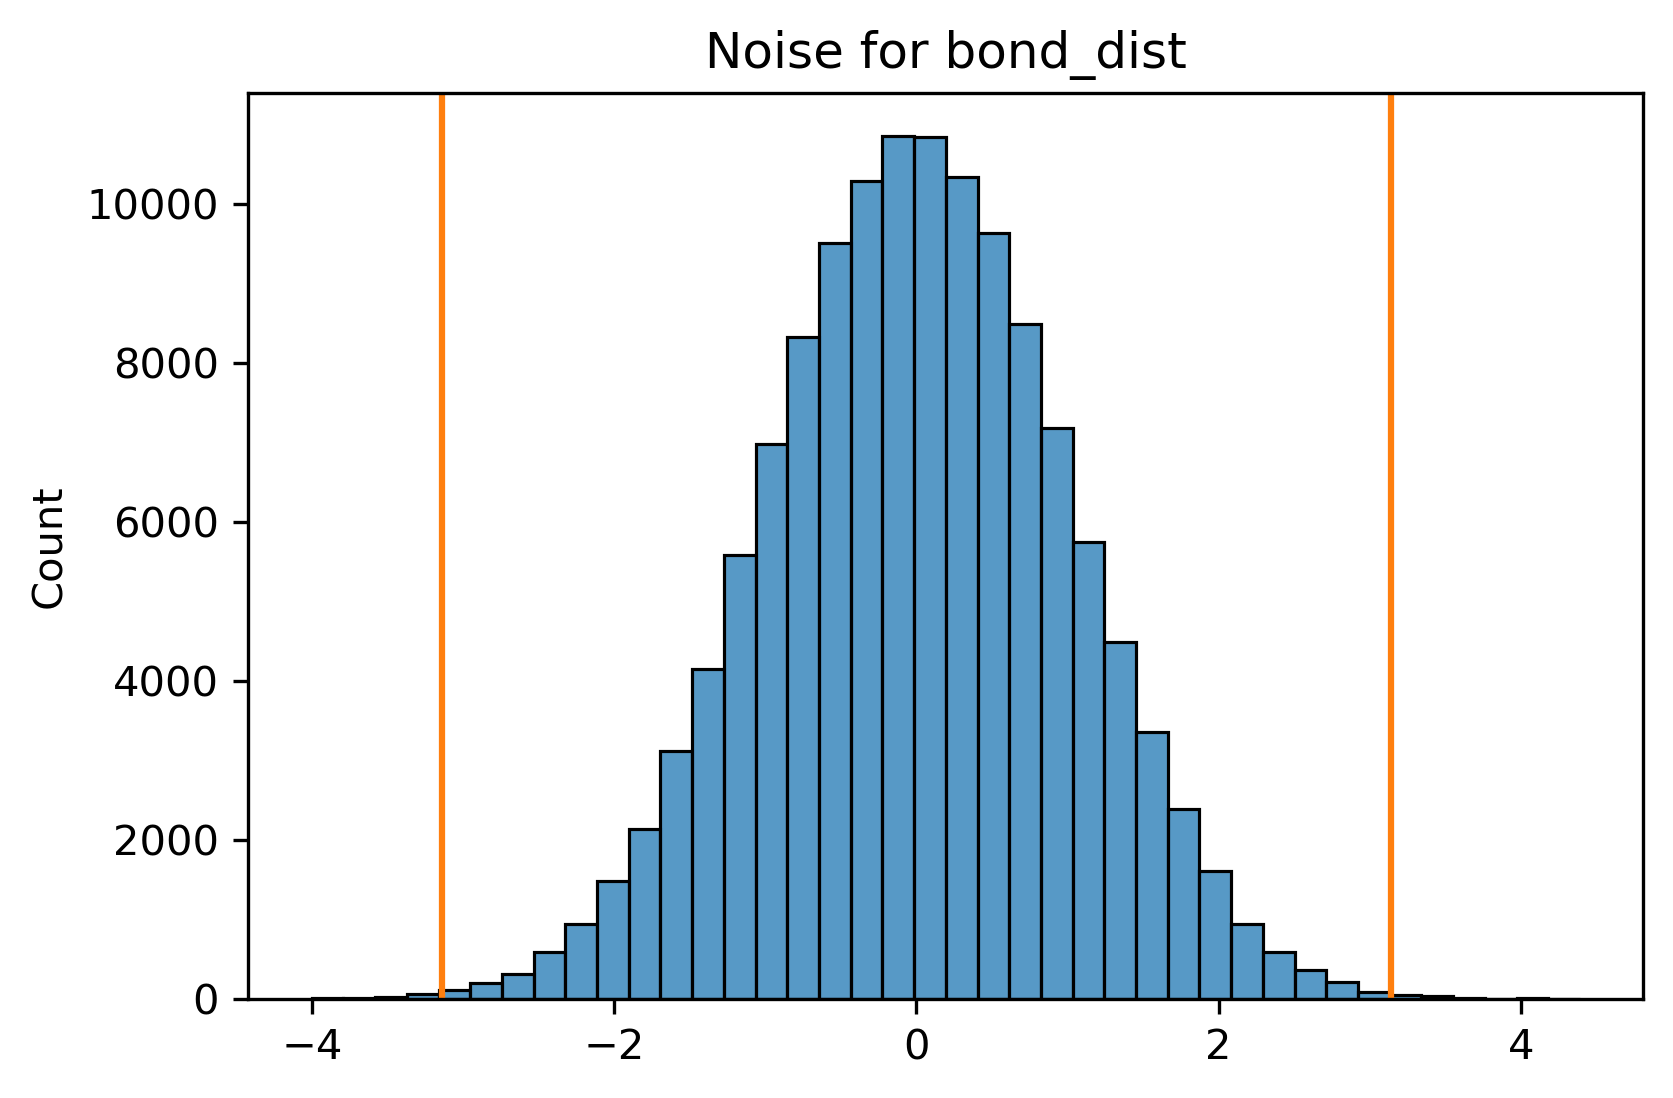

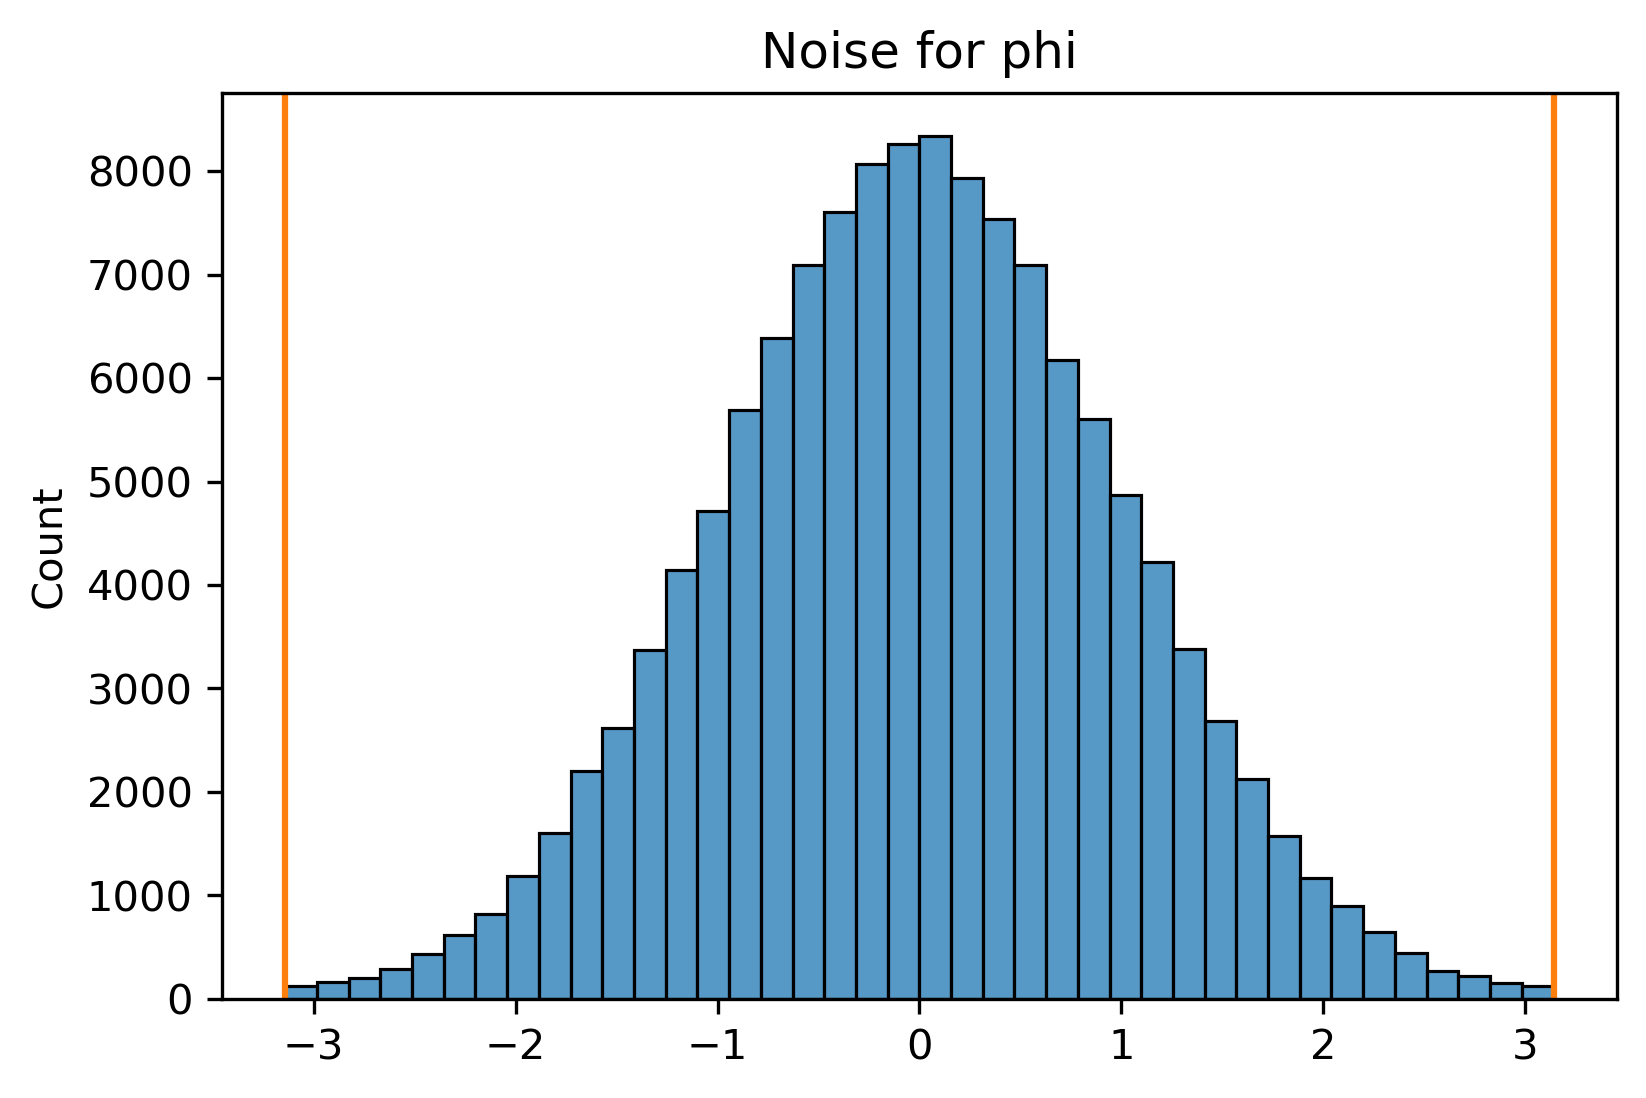

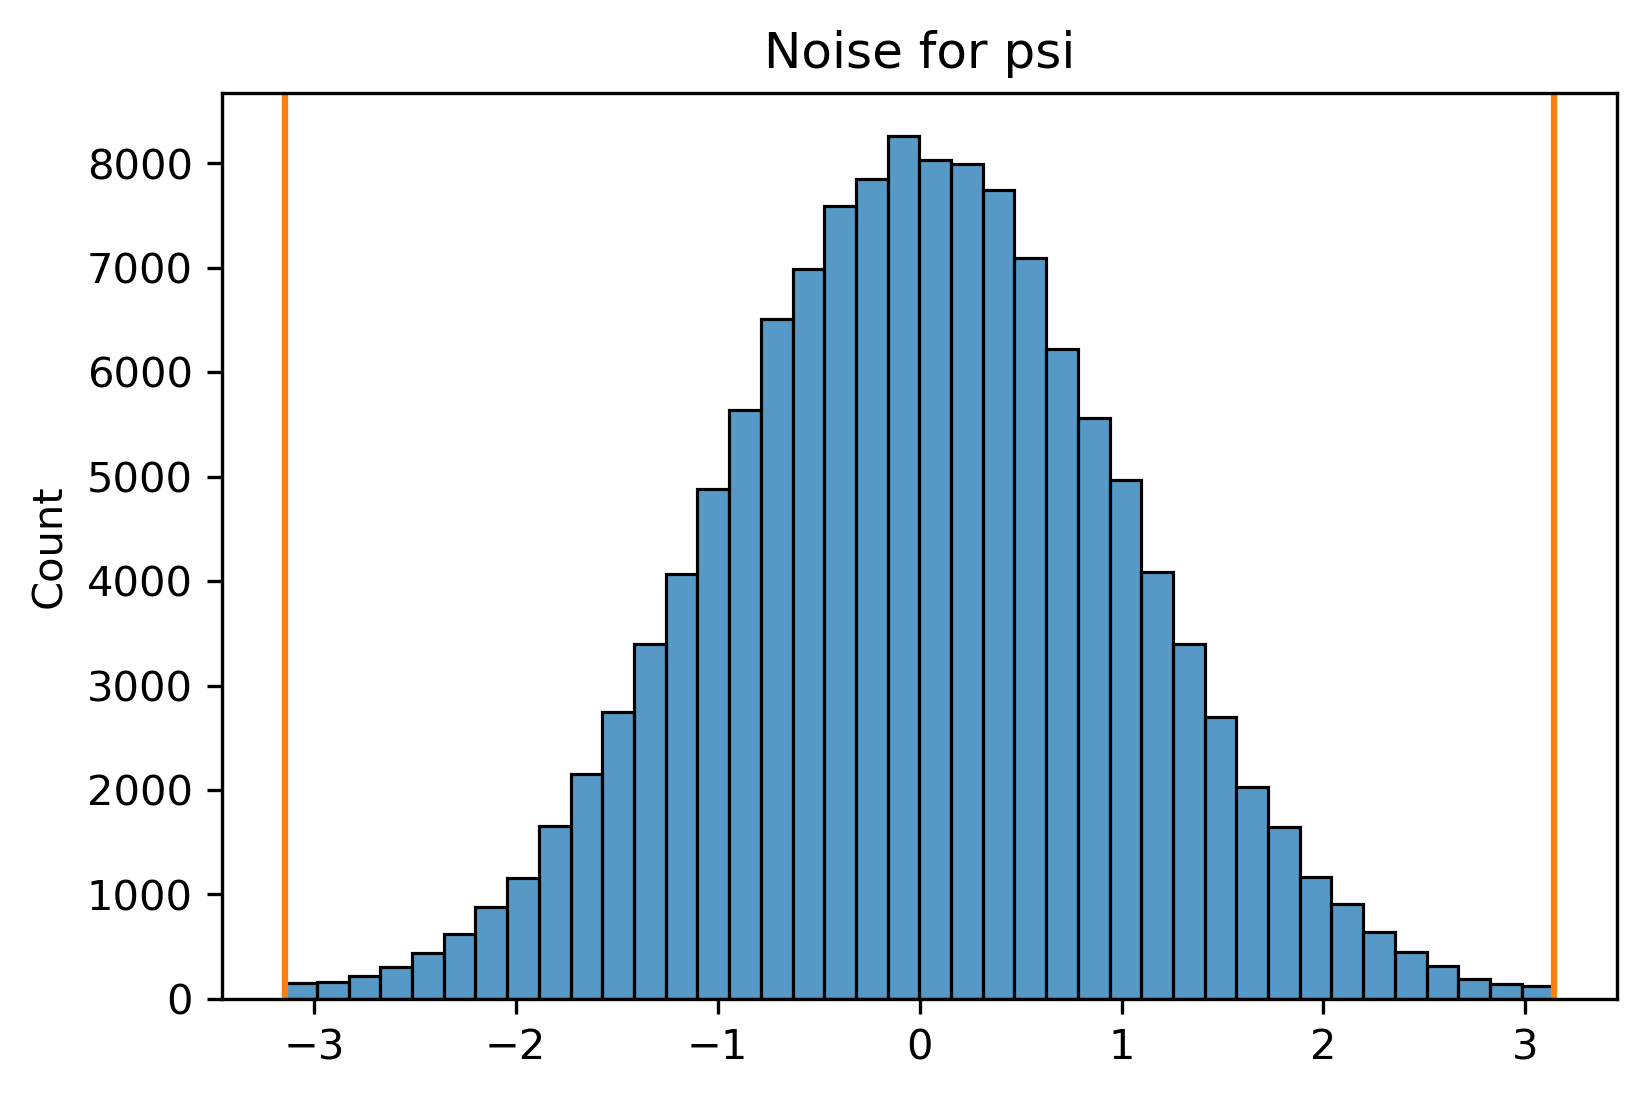

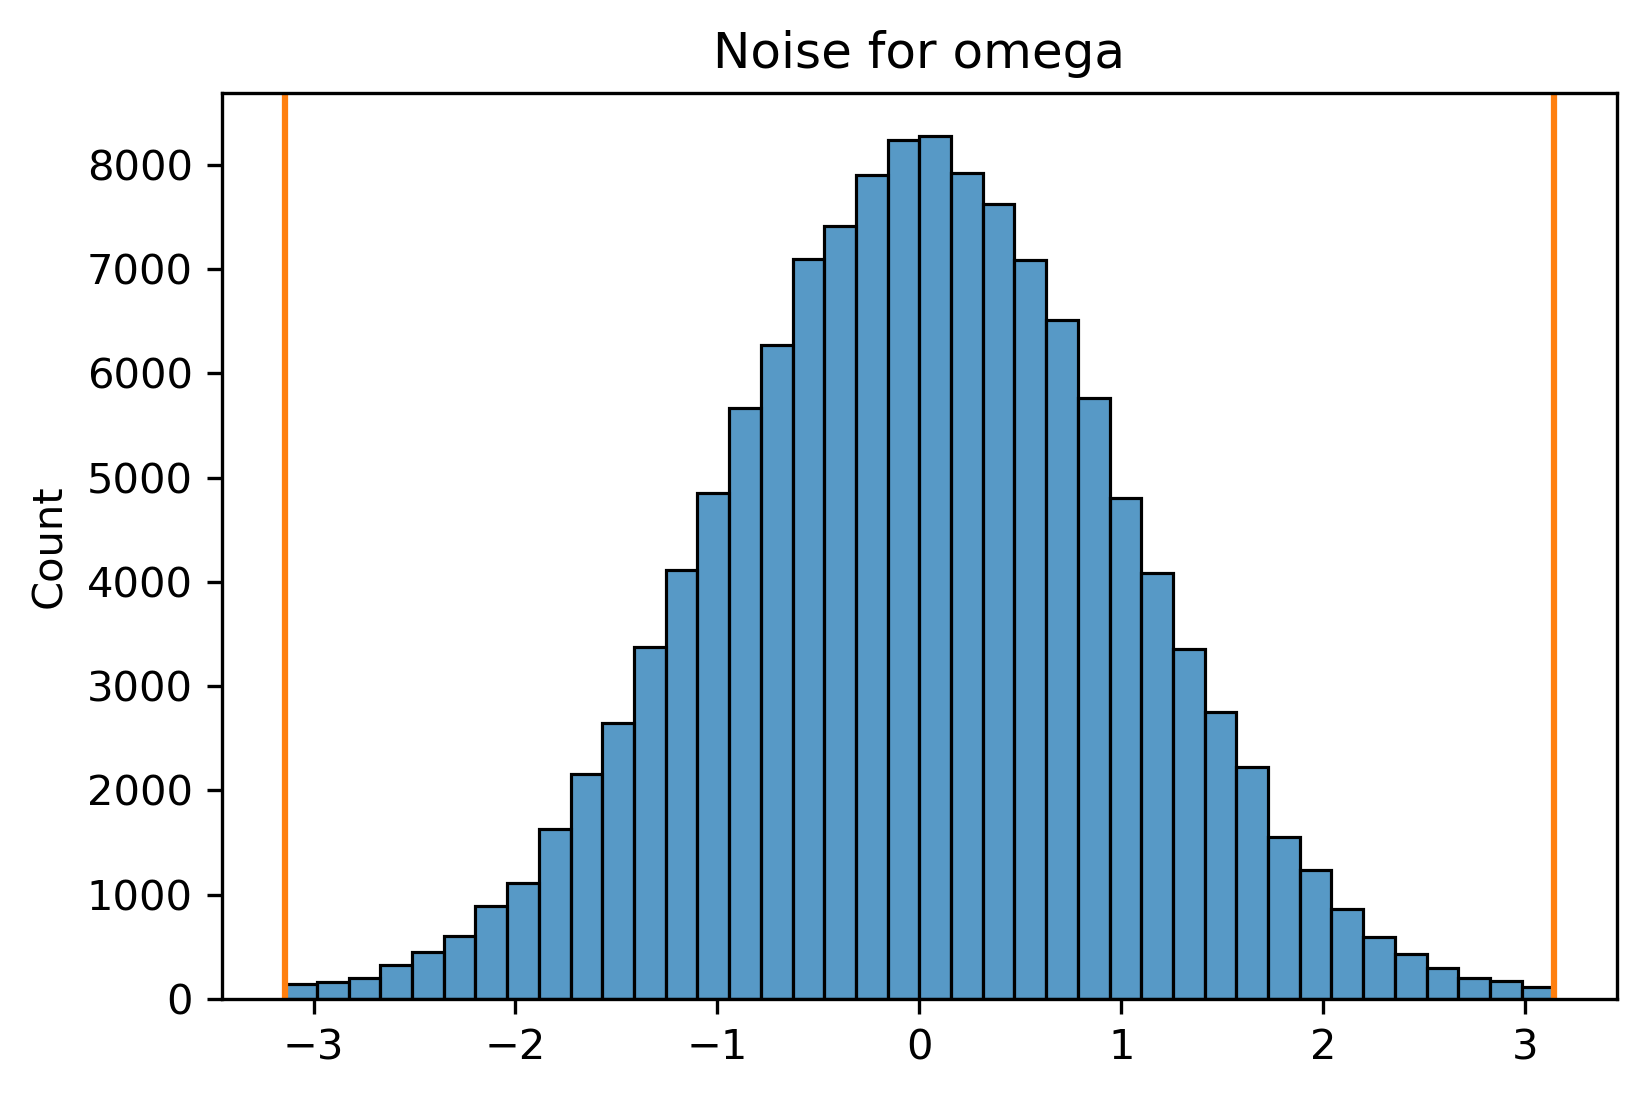

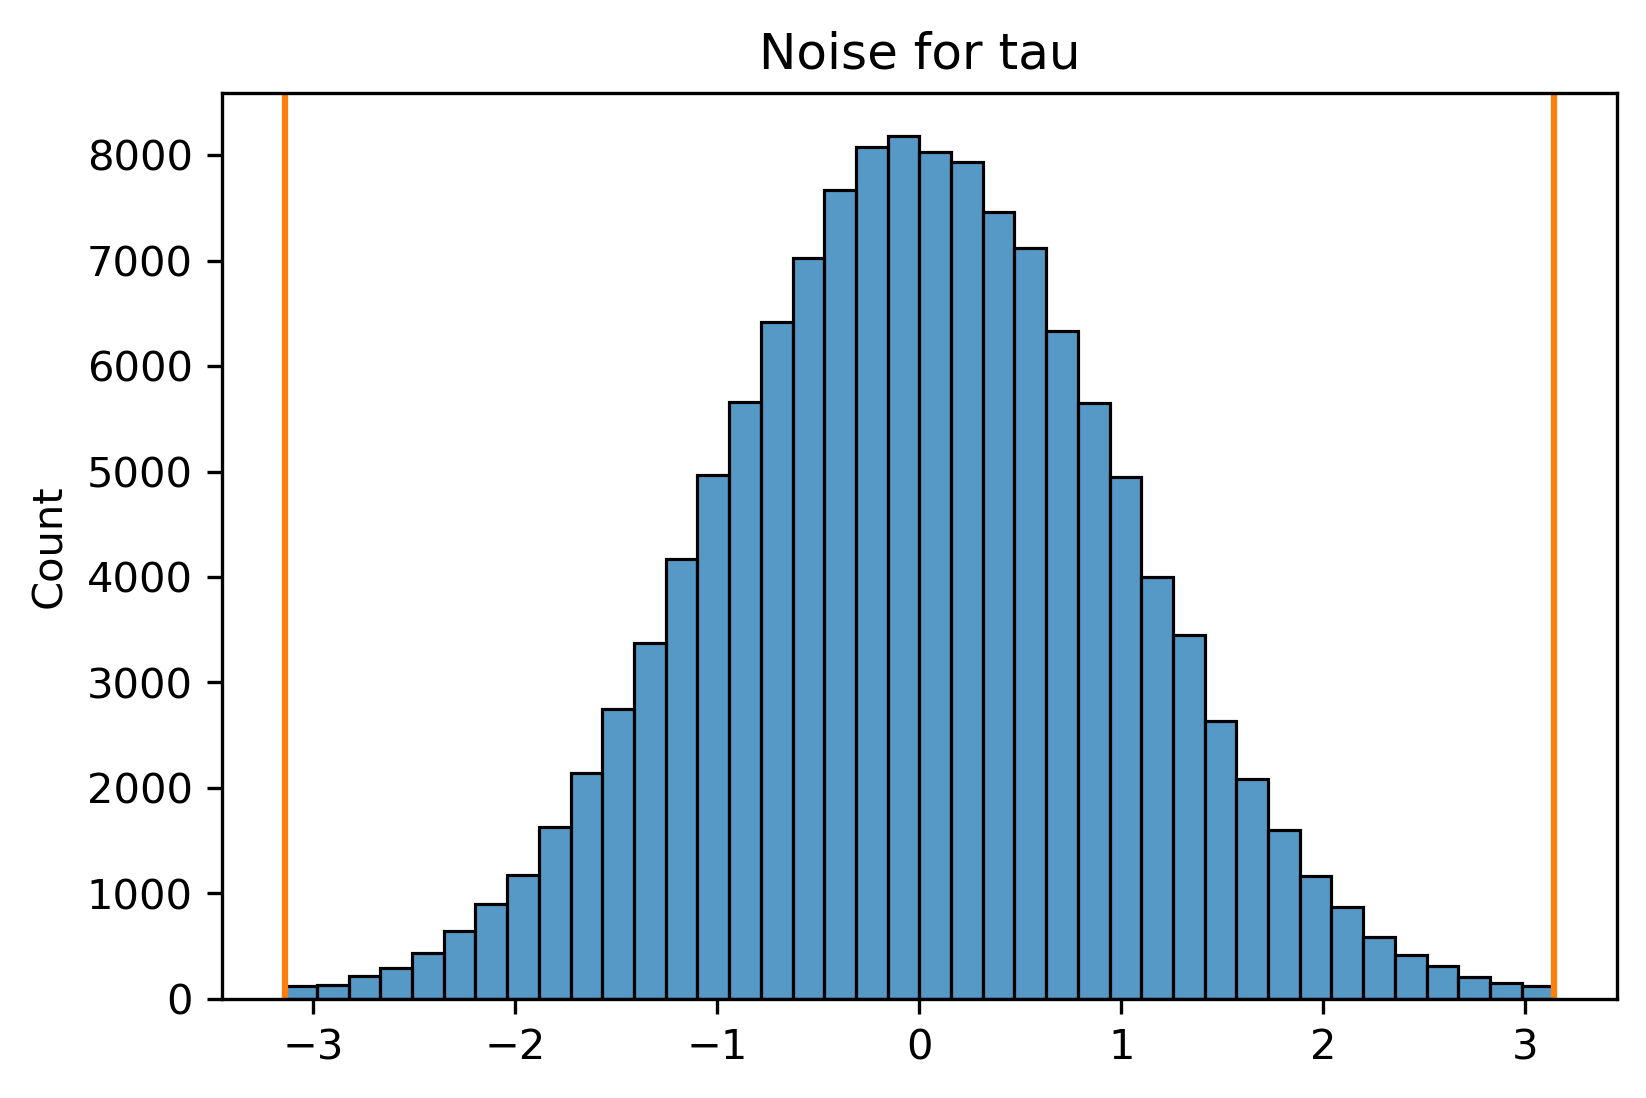

In [39]:
importlib.reload(sampling)

n = 256

# Selects the noise for angle
noise = train_dset.sample_noise(
    torch.zeros((n, 512, model.n_inputs),
    dtype=torch.float32)
)

for i in range(model.n_inputs):
    ft_name = train_dset.dset.feature_names['angles'][i]

    fig, ax = plt.subplots(dpi=300)
    sns.histplot(noise.numpy()[:, :, i].flatten(), bins=40, ax=ax)
    ax.set(title=f"Noise for {ft_name}")
    ax.axvline(-np.pi, color='tab:orange')
    ax.axvline(np.pi, color='tab:orange')
    fig.show()

In [42]:
importlib.reload(modelling)
model = modelling.BertForDiffusion.from_dir(MODEL_DIR).to(torch.device('cuda'))

INFO:root:Loading model assuming new file structure
INFO:root:Found 5 checkpoints
INFO:root:Loading weights from /home/t-kevinwu/amlt/normal-cattle/cath_full_run/results/models/best_by_valid/epoch=897-step=354710.ckpt
INFO:root:Mapping loss smooth_l1 to list of losses corresponding to angular [False, True, True, True, True]
Using loss: [<function smooth_l1_loss at 0x7f75a12cf550>, functools.partial(<function radian_smooth_l1_loss at 0x7f757ab69dc0>, beta=0.3141592653589793), functools.partial(<function radian_smooth_l1_loss at 0x7f757ab69dc0>, beta=0.3141592653589793), functools.partial(<function radian_smooth_l1_loss at 0x7f757ab69dc0>, beta=0.3141592653589793), functools.partial(<function radian_smooth_l1_loss at 0x7f757ab69dc0>, beta=0.3141592653589793)]
Using time embedding: GaussianFourierProjection()


In [45]:
importlib.reload(sampling)

lengths = [train_dset.dset.sample_length() for _ in range(n)]

sampled = sampling.p_sample_loop(
    model=model,
    lengths=lengths,
    noise=torch.clone(noise),
    timesteps=training_args['timesteps'],
    betas=alpha_beta_values['betas'],
    is_angle=True,
)
sampled.shape

INFO:root:Starting from noise torch.Size([256, 512, 5]) with modulo None and range tensor([-4.0032, -3.1412, -3.1415, -3.1400, -3.1397], device='cuda:0') - tensor([4.3921, 3.1401, 3.1388, 3.1402, 3.1397], device='cuda:0') using cuda:0


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

torch.Size([250, 256, 512, 5])

In [48]:
final_sampled = [sampled[-1, i, :l, :] for i, l in enumerate(lengths)]
final_sampled[0].shape

torch.Size([94, 5])

In [49]:
final_sampled_flat = torch.cat(final_sampled, dim=0).squeeze()
final_sampled_flat.shape

torch.Size([41598, 5])

In [54]:
final_sampled_flat[:3]

tensor([[ 0.1559,  0.8090,  0.6221,  0.8328,  0.6903],
        [ 1.3073,  0.2161, -0.2280,  0.7422,  1.2444],
        [ 0.7989,  0.2254,  0.6092,  0.8247,  1.6340]])

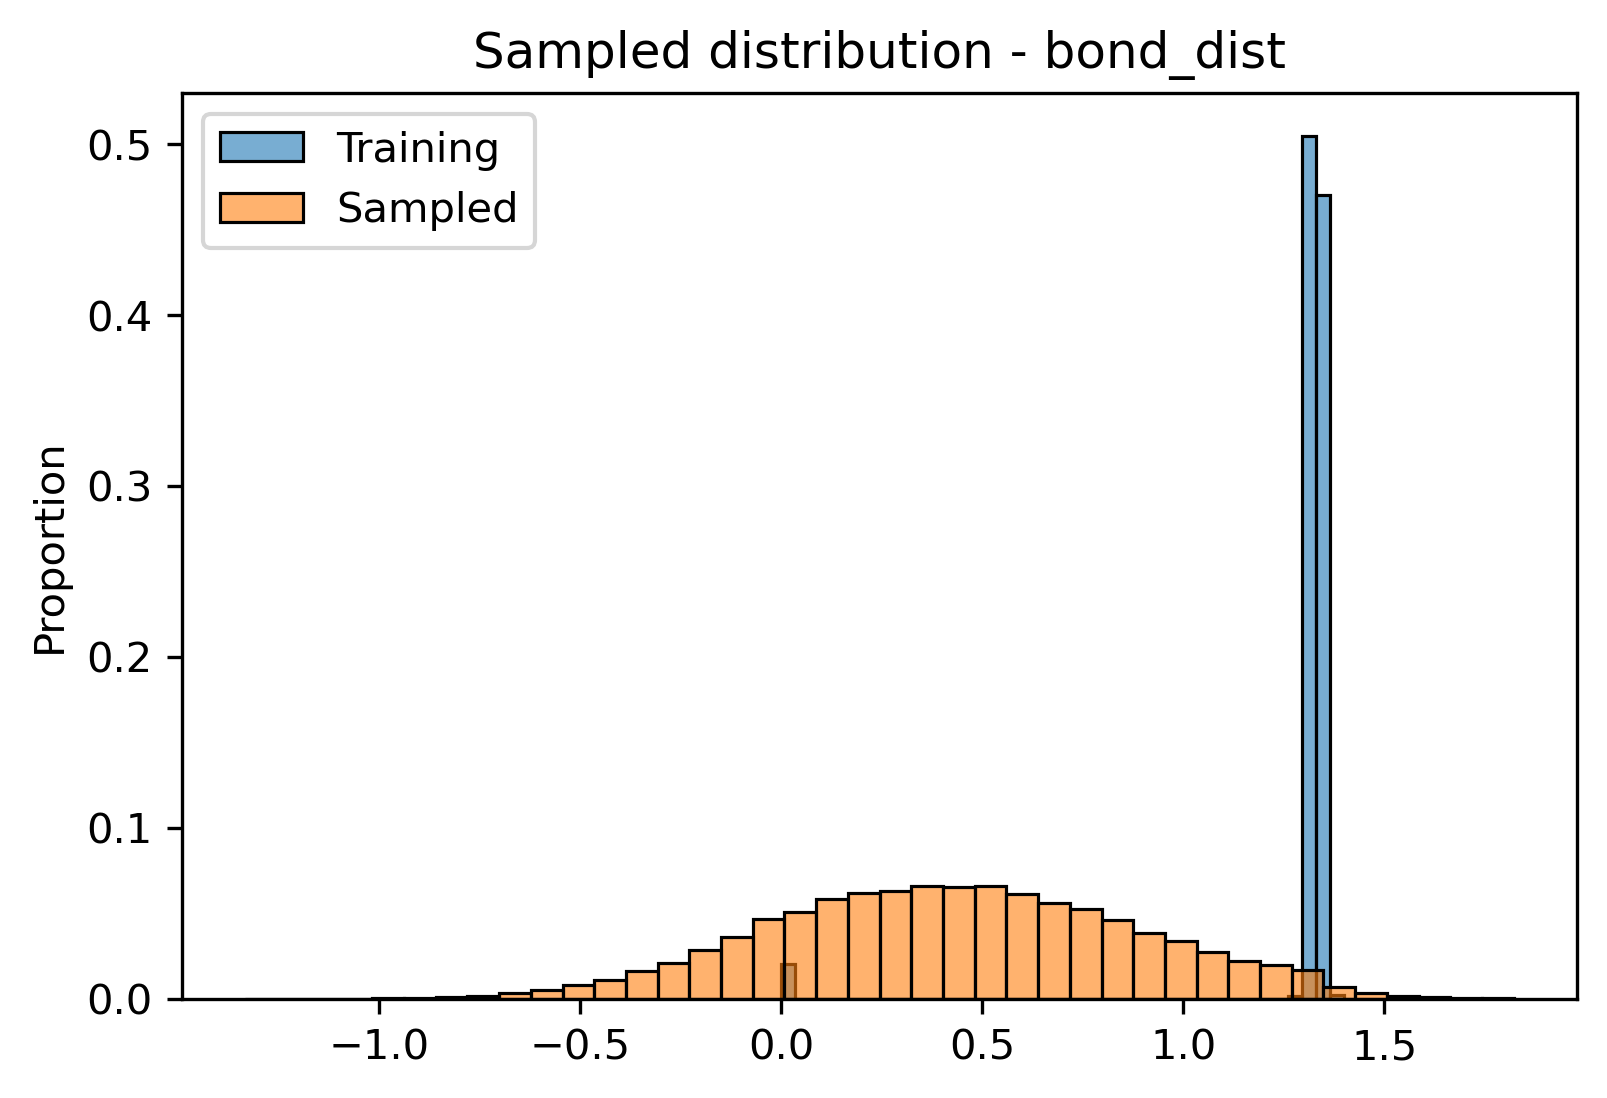

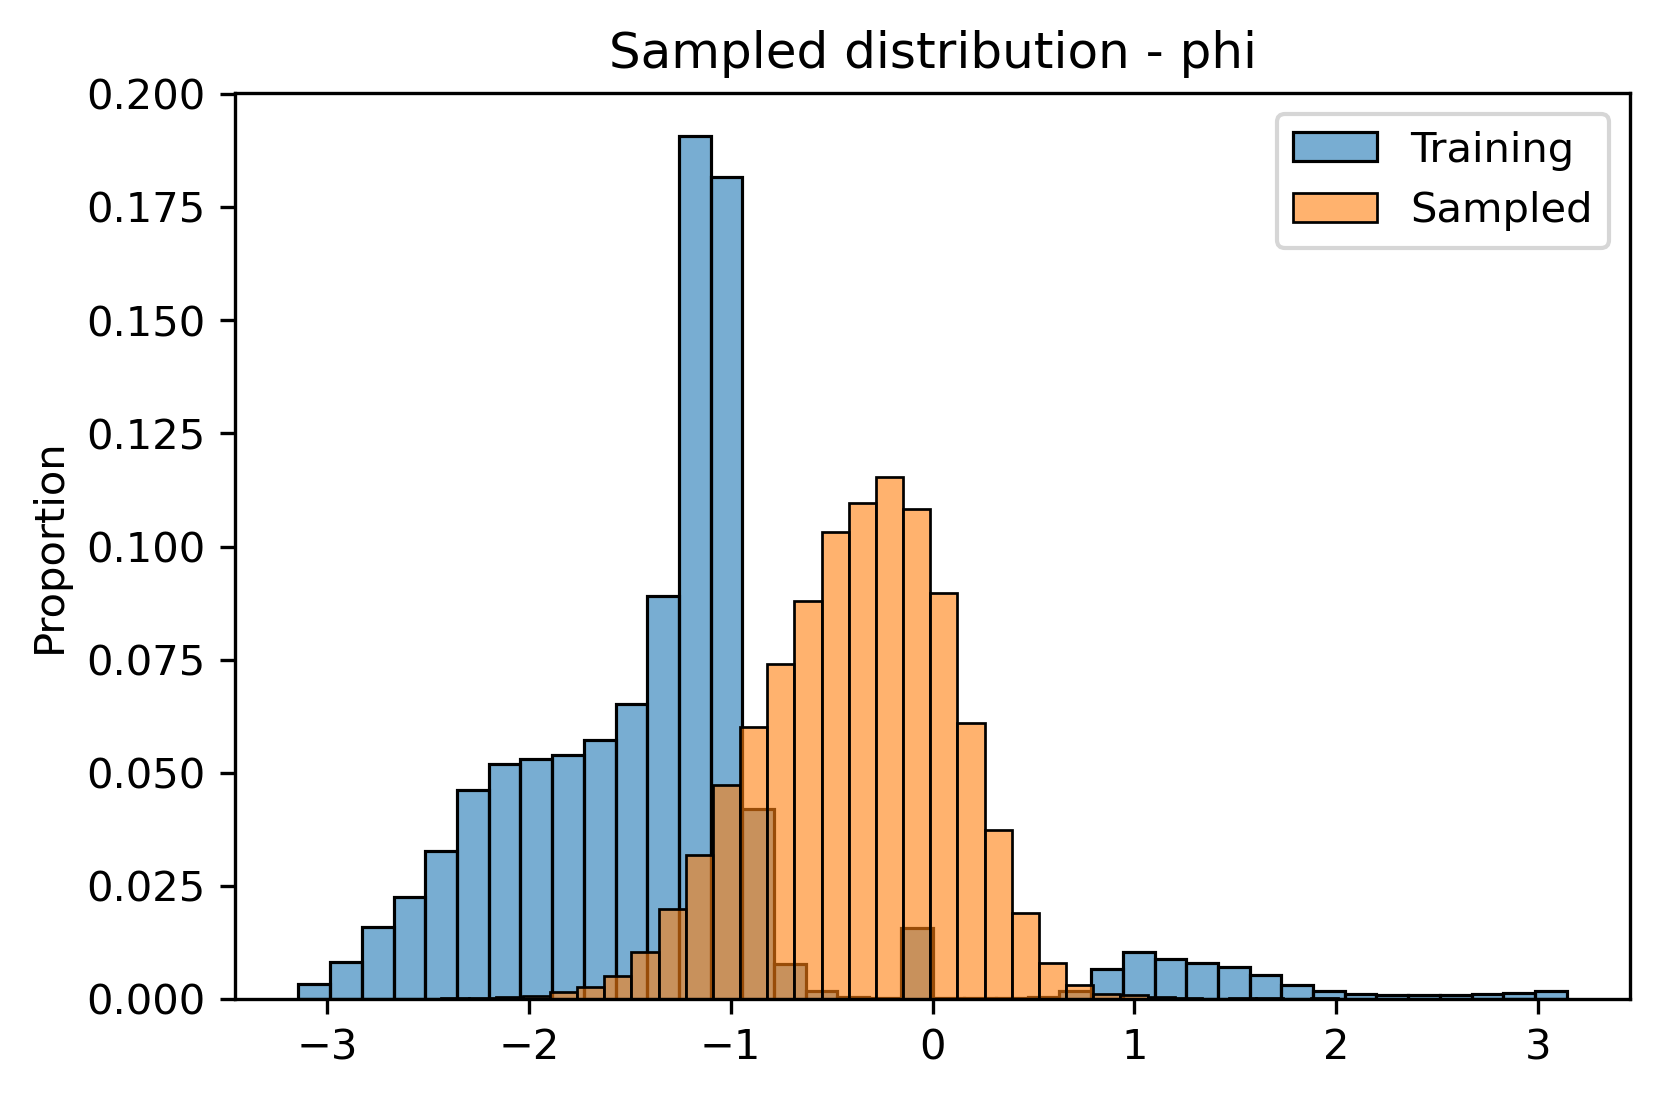

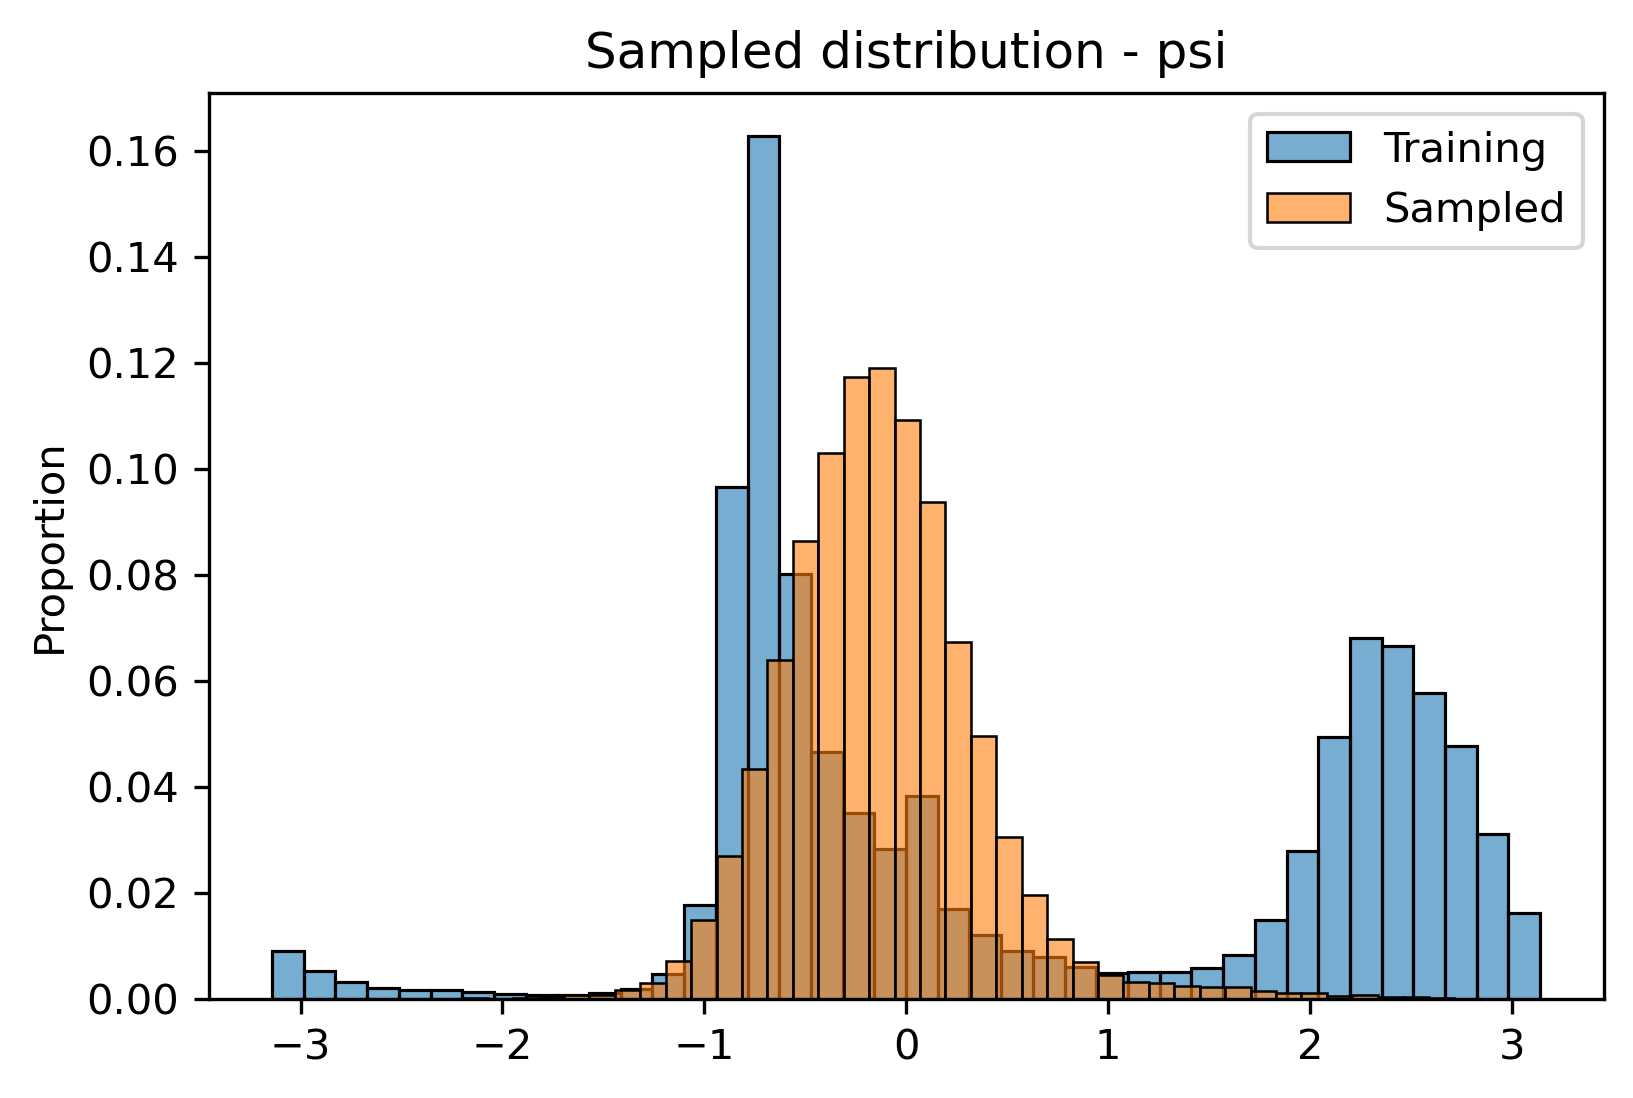

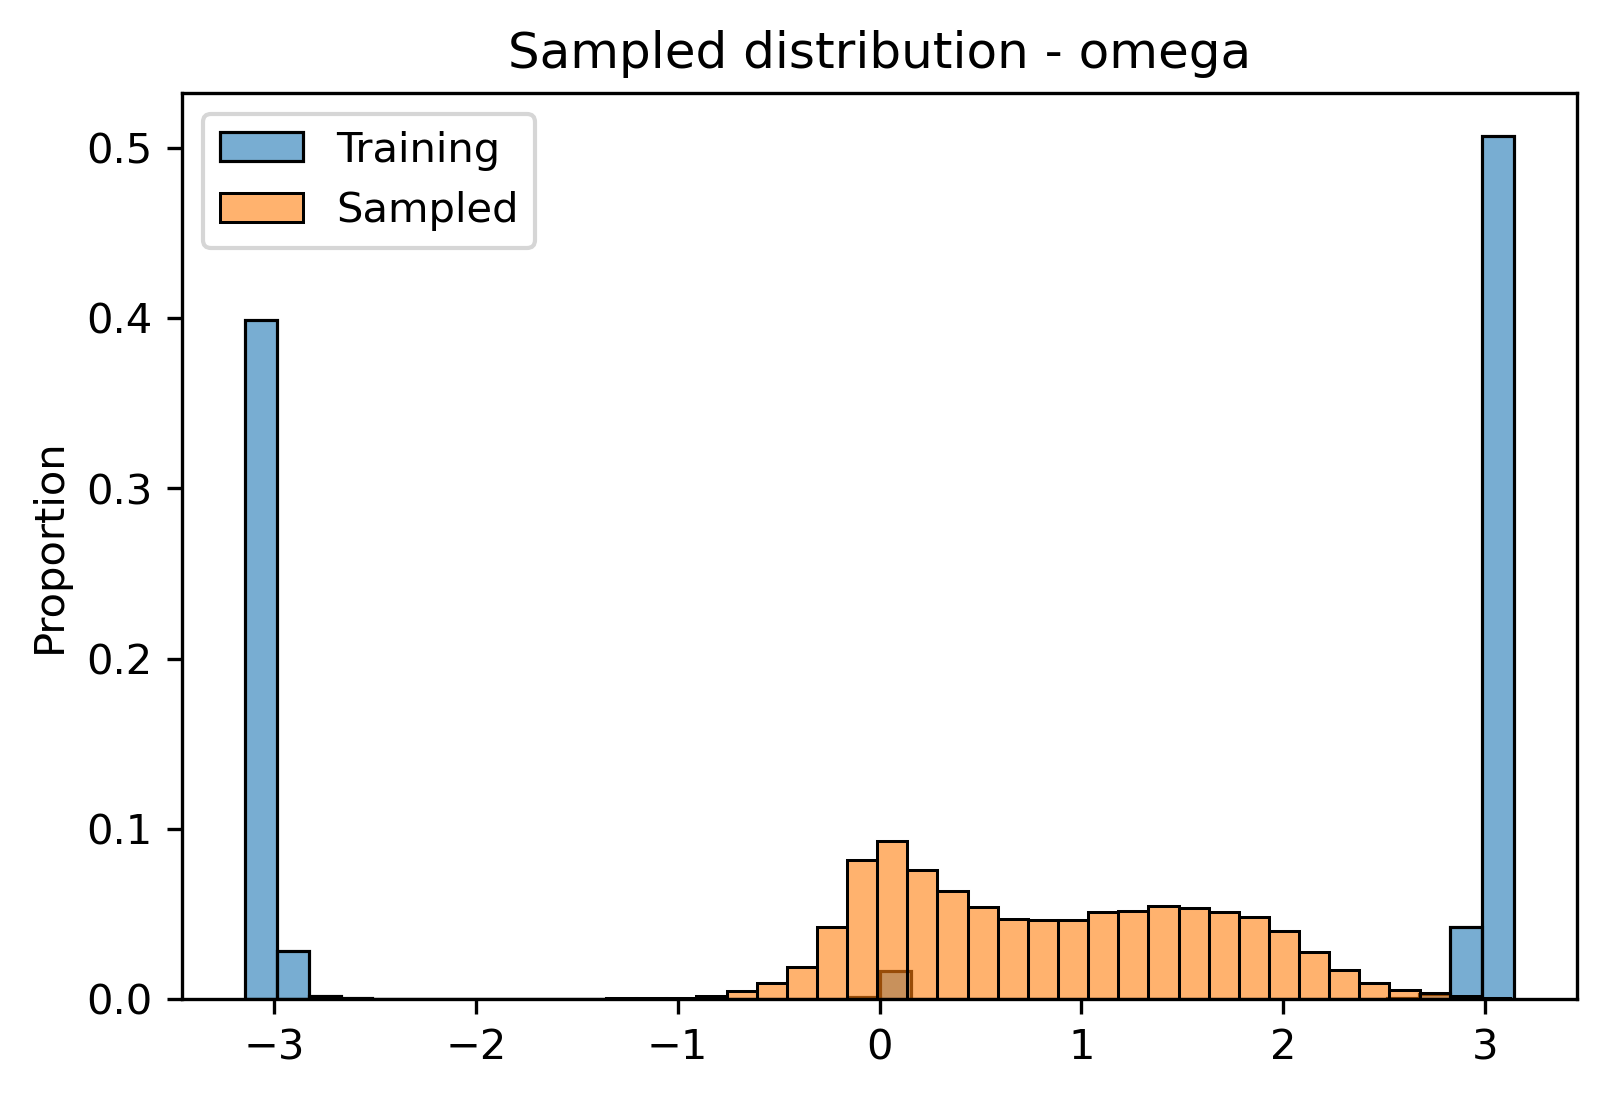

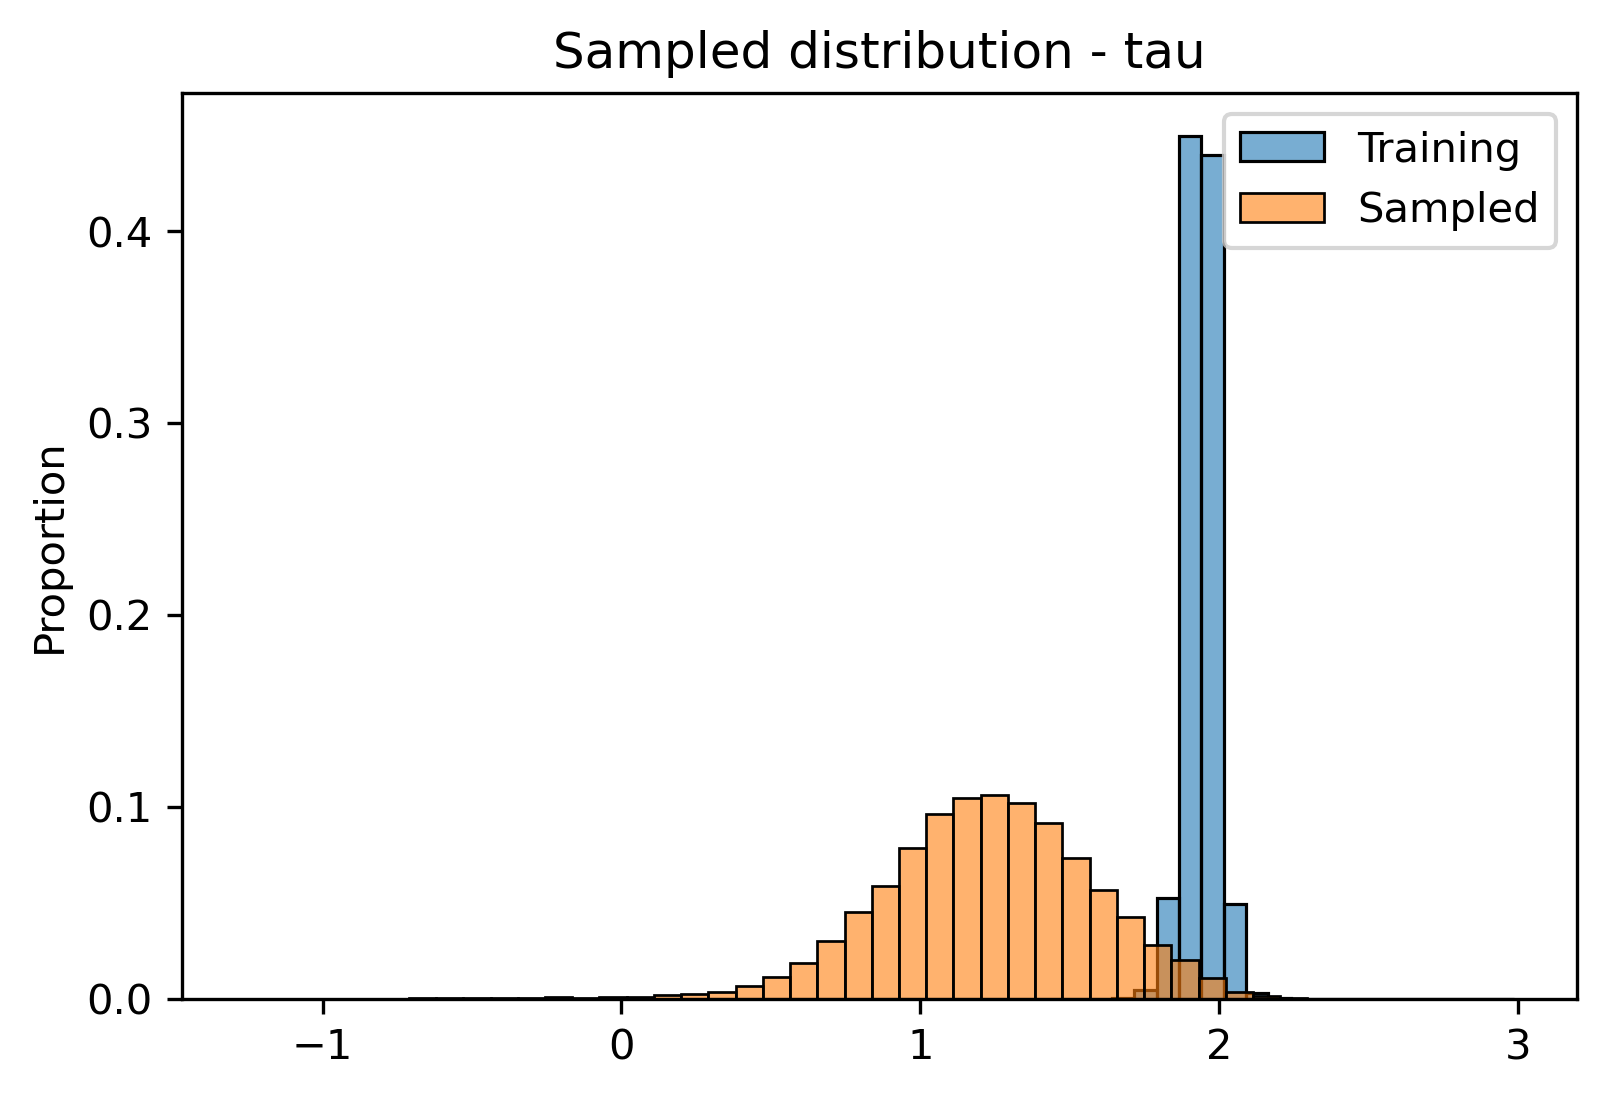

In [52]:
for i in range(model.n_inputs):
    ft_name = train_dset.dset.feature_names['angles'][i]

    fig, ax = plt.subplots(dpi=300)
    sns.histplot(train_values_stacked[:, i].numpy(), bins=40, stat='proportion',
        ax=ax, label='Training', color='tab:blue', alpha=0.6)
    sns.histplot(final_sampled_flat[:, i].numpy(), bins=40, stat='proportion', 
        ax=ax, label='Sampled', color='tab:orange', alpha=0.6)
    ax.set(title=f"Sampled distribution - {ft_name}")
    ax.legend()
    fig.show()